# ProductNet: Categorize products using image(s) and text descriptors
## Jen Sheng Wong and Kartik Nanda (Cohort 14)
Based on following paper: https://arxiv.org/pdf/1904.09037.pdf

## Problem Statement:
Relates primarily to products on retail/marketplace sites such as Amazon. The problem deals with 3 main aspects:
* Trying to categorize products. Number of categories ~5000 (using the Google taxonomy: https://github.com/fellowship/platform-demos3/blob/master/ProductNet/taxonomy-with-ids.en-US.xls)
* Product has images (1 or more)
* Product has text - title, description, keywords

Possible end-problems to solve: 
a) Find the category, given product images and user provided text description. 
b) Find mis-categorized products

## Dataset: 
Products for sale on Amazon; product details from 1996 through 2014, by Prof. McAuley at UCSD
Citations:
* R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
* J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

## Dataset Storage:
* Used Google storage bucket located at gs://platform-ai-research/datasets/ProductNet/
* Also used Jen Sheng's Google Drive for intermediate files, images etc

In [0]:
!pip install fastai

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os

from fastai.vision import *


## Cleaning the Dataset
Our initial challenges were dealing with the dataset. 
* Its 9.5 million entries. Many of them we can not easily use (example Books, Videos etc). Initial steps: dealing with the size and the initial cleaning - these are captured in a separate script: https://github.com/fellowship/platform-demos3/blob/master/ProductNet/workbook_1.ipynb
* Clean up the category, names - reduce the number of categories we are dealing with. In the beginning only 40 categories. This is probably not ideal because the categories are very high level, and it might actually result in worse numbers.
* Data distribution across categories is not balanced. Decided to sub-sample, which has 2 benefits: a) Reduces the size of the dataset to something more manageable (from 6.5 million at the and of step 1); b) provides a balanced distribution between the various categories
* Download the image files using the urls in the dataset. These were stored in Google Drive. Missing instances were removed from the dataset.

In [3]:
# Set the file name - this is the output file from step1 (workbook_1)
file_name = 'df_from_splits_1thru6'

# set local to False if running on Colab
local = False      # this needs to be automated (how?)

# Reading in the datafile
exists = os.path.isfile(file_name)
if (not exists):
    if (not local):
        # Login to access the GS bucket
        from google.colab import auth
        auth.authenticate_user()

        # Copy the datafile to the Colab local dir
        gs_path = 'platform-ai-research/datasets/ProductNet/'
        remote_file = gs_path + file_name
        !gsutil cp gs://{remote_file} {file_name}
                
    else: 
        print('File Does Not Exist')
        sys.exit()

# Read in the file
df = pd.read_csv(file_name)

# Drop records with missing labels
df.dropna(subset=['label'], inplace=True)

Copying gs://platform-ai-research/datasets/ProductNet/df_from_splits_1thru6...
/ [1 files][402.4 MiB/402.4 MiB]                                                
Operation completed over 1 objects/402.4 MiB.                                    


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 635494 entries, 0 to 667270
Data columns (total 7 columns):
Unnamed: 0     635494 non-null int64
asin           635494 non-null object
categories     635494 non-null object
description    522466 non-null object
imUrl          634637 non-null object
title          631505 non-null object
label          635494 non-null object
dtypes: int64(1), object(6)
memory usage: 38.8+ MB


In [5]:
# See the distribution of the categories
xx = np.array([])
yy = np.array([])
for l in df.label.unique():
    i = len(df[df.label == l])
    print('label = ', l, ' Number of instances = ', str(i))
    xx = np.append(xx,[l])
    yy = np.append(yy,[i])

label =  Clothing  Number of instances =  59008
label =  Sports & Outdoors  Number of instances =  50505
label =  Toys & Games  Number of instances =  60419
label =  Musical Instruments  Number of instances =  15578
label =  Tools & Home Improvement  Number of instances =  55565
label =  Home & Kitchen  Number of instances =  63347
label =  Health & Personal Care  Number of instances =  36631
label =  Cell Phones & Accessories  Number of instances =  8545
label =  Office Products  Number of instances =  20231
label =  Electronics  Number of instances =  73982
label =  Office & School Supplies  Number of instances =  513
label =  Baby  Number of instances =  7684
label =  Beauty  Number of instances =  28825
label =  Automotive  Number of instances =  68932
label =  Arts  Number of instances =  5744
label =  Computers  Number of instances =  837
label =  All Electronics  Number of instances =  3083
label =  Pet Supplies  Number of instances =  19821
label =  Grocery & Gourmet Food  Numb

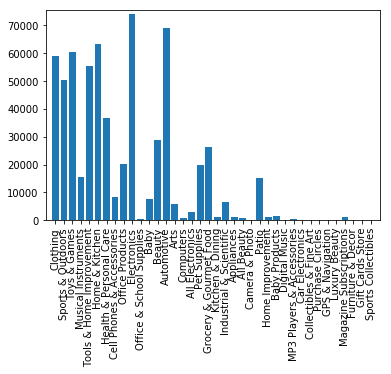

In [6]:
# Plot the distribution
plt.bar(range(1,len(yy)+1), yy)
labels = xx
plt.xticks(range(1,len(yy)+1), labels, rotation='vertical')
plt.margins(0.02)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [0]:
# Calculate weights for categories
# Need an even distributed dataset - all categories should have approx. same number of instances
def calc_weight(label):
    wt = 1/int(yy[np.where(xx==label)])
    return wt

In [0]:
df['weight'] = df.label.apply(calc_weight)

In [29]:
# Sum of all the weights should be equal to the number of categories
sum(df.weight)

37.9999999999994

In [0]:
# The distribution is uneven, assign weights and subsample unevenly
df2 = df.sample(n=10000, weights='weight', random_state=1)

In [37]:
# See the distribution of the categories
xx = np.array([])
yy = np.array([])
for l in df2.label.unique():
    i = len(df2[df2.label == l])
    print('label = ', l, ' Number of instances = ', str(i))
    xx = np.append(xx,[l])
    yy = np.append(yy,[i])

label =  Kitchen & Dining  Number of instances =  314
label =  Appliances  Number of instances =  307
label =  Arts  Number of instances =  371
label =  Digital Music  Number of instances =  5
label =  Tools & Home Improvement  Number of instances =  367
label =  Computers  Number of instances =  302
label =  Grocery & Gourmet Food  Number of instances =  337
label =  Gift Cards Store  Number of instances =  1
label =  Car Electronics  Number of instances =  85
label =  Electronics  Number of instances =  331
label =  Magazine Subscriptions  Number of instances =  319
label =  Camera & Photo  Number of instances =  125
label =  Industrial & Scientific  Number of instances =  332
label =  All Electronics  Number of instances =  316
label =  Baby  Number of instances =  370
label =  Automotive  Number of instances =  374
label =  GPS & Navigation  Number of instances =  97
label =  Furniture & Decor  Number of instances =  24
label =  Home Improvement  Number of instances =  320
label = 

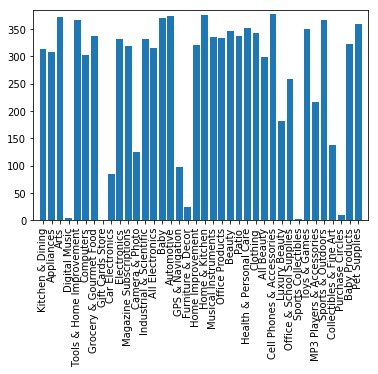

In [38]:
# Plot the distribution
plt.bar(range(1,len(yy)+1), yy)
labels = xx
plt.xticks(range(1,len(yy)+1), labels, rotation='vertical')
plt.margins(0.02)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [0]:
# Next step is to download the images
if (not os.path.exists('./images/')):
    !mkdir 'images'

In [0]:
imUrls = df2.imUrl.tolist()
asins = df2.asin.tolist()

# %%time
for url_id in zip(imUrls, asins):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    filename = './images/' + asin + '.jpg'
  
    # also check if file exists. If it does, do not reload it!
    if (not os.path.isfile(filename)):
        try:
            r = requests.get(url, allow_redirects=True)
            open(filename, 'wb').write(r.content)
    
        except Exception as e:
            df2 = df2[df2.asin != asin]           # if missing, remove from dataset
            with open("./missing.txt", "a") as f:
                f.write(asin+'\n')

In [0]:
df2.to_csv('train_v0.csv', columns=['asin', 'label'], index=False)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv('./', 'train_v0.csv', folder='images', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
tfms = get_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

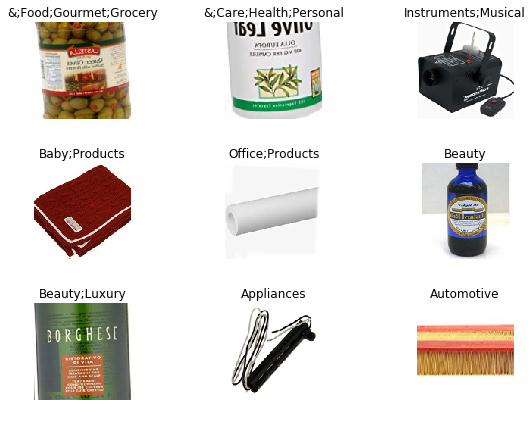

In [59]:
data.show_batch(rows=3, figsize=(8,6))

9906


,Unnamed: 0,asin,categories,description,imUrl,title,label,weight
247081,247082,B0007UQYC6,Kitchen & Dining,NaN,NaN,NaN,Kitchen & Dining,0.000779
486907,486915,B000GZ6KIU,"Appliances, Washers & Dryers, Washers",Features: 4.0 cu. ft. capacity allows you to d...,http://ecx.images-amazon.com/images/I/41qRVcWm...,NaN,Appliances,0.000904
106,106,0307586758,"Arts, Crafts & Sewing","""A growing number of nostalgic hobbyists latel...",http://ecx.images-amazon.com/images/I/51LOS3OD...,BurdaStyle Sewing Vintage Modern: Mastering Ic...,Arts,0.000174
185472,185473,B0002YLAYE,"Digital Music, R&B, Soul",NaN,http://ecx.images-amazon.com/images/I/518NFSwd...,Mamani Live,Digital Music,0.200000
75002,75002,B00008X5D5,"Tools & Home Improvement, Kitchen & Bath Fixtu...",The Skylink WS-100/WS-100N Wireless Remote Con...,http://ecx.images-amazon.com/images/I/31FEnwvd...,Skylink WS-100/WS-100N Wireless Remote Control...,Tools & Home Improvement,0.000018
